In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
tf.keras.backend.set_floatx('float64')

# set random seed for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# simple nn
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1)
    
    def call(self, txy):
        x = self.dense1(txy)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return x

In [3]:
# idk exact values to use here
k = 1.0    # production rate
gamma = 0.1  # decay rate
D = 0.01  # diffusion coefficient

def loss_fn(model, txy_data, C_data):
    # convert to tensors
    txy_data = tf.convert_to_tensor(txy_data)
    C_data = tf.convert_to_tensor(C_data)

    # data loss
    C_pred = model(txy_data)
    data_loss = tf.reduce_mean(tf.square(C_pred - C_data))
    
    # physics loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(txy_data)
        C_pred = model(txy_data)
        
        # compute gradients
        C_t = tape.gradient(C_pred, txy_data)[:, 0:1]
        C_x = tape.gradient(C_pred, txy_data)[:, 1:2]
        C_y = tape.gradient(C_pred, txy_data)[:, 2:3]
        
    # compute second-order gradients
    C_xx = tape.gradient(C_x, txy_data)[:, 1:2]
    C_yy = tape.gradient(C_y, txy_data)[:, 2:3]
    
    del tape
    
    # PDE residual
    physics_residual = C_t - D * (C_xx + C_yy) - (k - gamma * C_pred)
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    
    return data_loss + physics_loss

In [5]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/1st run concat.csv"
data = pd.read_csv(sorted_concatenated_csv)
data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

   mcsteps  xCOM  yCOM           il8  il1  il6  il10  tnf  tgf
0        0    33    22  3.750408e-07  0.0  0.0   0.0  0.0  0.0
1        0    11    32  4.793328e-09  0.0  0.0   0.0  0.0  0.0
2        0    30    35  8.997935e-09  0.0  0.0   0.0  0.0  0.0
3        0    17    40  1.781103e-08  0.0  0.0   0.0  0.0  0.0
4        0    21    23  4.789621e-09  0.0  0.0   0.0  0.0  0.0
       time  xCOM  yCOM           il8           il1           il6  \
0         0    33    22  3.750408e-07  0.000000e+00  0.000000e+00   
1         0    11    32  4.793328e-09  0.000000e+00  0.000000e+00   
2         0    30    35  8.997935e-09  0.000000e+00  0.000000e+00   
3         0    17    40  1.781103e-08  0.000000e+00  0.000000e+00   
4         0    21    23  4.789621e-09  0.000000e+00  0.000000e+00   
...     ...   ...   ...           ...           ...           ...   
86155   100    49    35 -8.886183e-11  6.343394e-10  1.206925e-08   
86156   100    36     4  1.334245e-07  1.665160e-07  1.305691e-08   
8

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_9528\3945162383.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_9528\3945162383.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_9528\3945162383.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\i

In [6]:
# load cytokine data
t_data = data['time'].values.reshape(-1, 1).astype(np.float64)
x_data = data['xCOM'].values.reshape(-1, 1).astype(np.float64)
y_data = data['yCOM'].values.reshape(-1, 1).astype(np.float64)
il8_data = data['il8'].values.reshape(-1, 1).astype(np.float64)
il1_data = data['il1'].values.reshape(-1, 1).astype(np.float64)
il6_data = data['il6'].values.reshape(-1, 1).astype(np.float64)
il10_data = data['il10'].values.reshape(-1, 1).astype(np.float64)
tnf_data = data['tnf'].values.reshape(-1, 1).astype(np.float64)
tgf_data = data['tgf'].values.reshape(-1, 1).astype(np.float64)

C_data = np.hstack((il8_data, il1_data, il6_data, il10_data, tnf_data, tgf_data))

In [8]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,  # How often to decay the learning rate
    decay_rate=0.9,  # The decay rate
    staircase=True
)

In [9]:
# Combine t, X, and Y into a single array
txy_data = np.hstack([t_data, x_data, y_data])
# Define model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define batch size
batch_size = 100
num_batches = len(txy_data) // batch_size

# train
epochs = 10
for epoch in range(epochs):
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        txy_batch = txy_data[batch_start:batch_end]
        C_batch = C_data[batch_start:batch_end]
        
        with tf.GradientTape() as tape:
            loss = loss_fn(model, txy_batch, C_batch)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Sub]

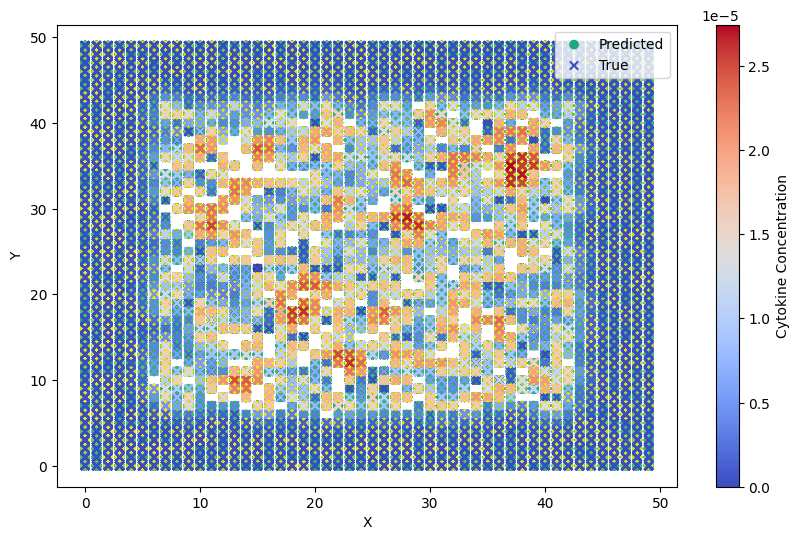

In [22]:
C_pred = model(txy_data).numpy()
plt.figure(figsize=(10, 6))
plt.scatter(txy_data[:, 1], txy_data[:, 2], c=C_pred, cmap='viridis', label='Predicted')
plt.scatter(txy_data[:, 1], txy_data[:, 2], c=C_data, cmap='coolwarm', marker='x', label='True')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Cytokine Concentration')
plt.legend()
plt.show()

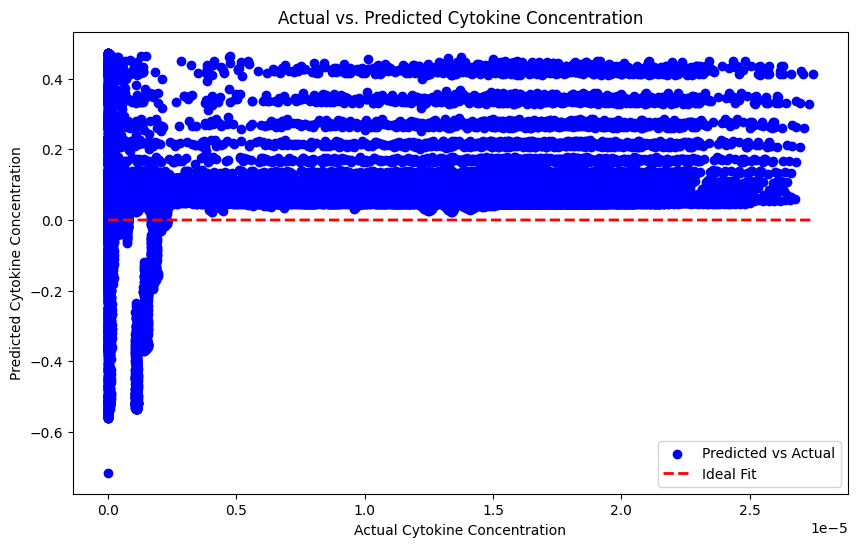

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(C_data, C_pred, c='blue', marker='o', label='Predicted vs Actual')
plt.plot([C_data.min(), C_data.max()], [C_data.min(), C_data.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Cytokine Concentration')
plt.ylabel('Predicted Cytokine Concentration')
plt.title('Actual vs. Predicted Cytokine Concentration')
plt.legend()
plt.show()

In [24]:
C_pred = model(txy_data).numpy()

# save predictions to csv file
predictions = pd.DataFrame({
    'time': t_data.flatten(),
    'X': x_data.flatten(),
    'Y': y_data.flatten(),
    'actual_cytokine_concentration': C_data.flatten(),
    'predicted_cytokine_concentration': C_pred.flatten()
})

predictions.to_csv('data/predicted_cytokine_concentrations.csv', index=False)